# Monday, May 1st, 2023

In [1]:
import requests
import re

In [2]:
page = requests.get('https://www.gutenberg.org/cache/epub/70635/pg70635.txt')

In [3]:
text = page.text

In [4]:
print(text[3000:4000])

ters
pertaining to print, is at least encouraging, and this leads me to say
that of my earlier plays there have been sold in paper covers _three
hundred and twenty thousand copies_, besides an edition in cloth.

                                                               THE AUTHOR.

Chicago, July 11, 1895.




                               TOPP’S TWINS

                       A FARCE-COMEDY IN FOUR ACTS

                             BY T. S. DENISON

                               _Author of_
  Odds with the Enemy, Initiating a Granger, Wanted, a Correspondent, A
    Family Strike, Seth Greenback, Louva, the Pauper, Hans Von Smash,
 Borrowing Trouble, Two Ghosts in White, The Pull-Back, Country Justice,
        The Assessor, The Sparkling Cup, Our Country, Irish Linen
     Peddler, The School Ma’am, Kansas Immigrants, An Only Daughter,
         Too Much of a Good Thing, Under the Laurels, Hard Cider,
         The Danger Signal, Wide Enough for Two, Pets of


The `^` is used as a logical `not` in RegEx:

In [5]:
pattern = r'\b[oO][\w]*s\b'
matches = re.findall(pattern,text)
matches[:10]

['Outlines',
 'Odds',
 'odious',
 'oysters',
 'outrageous',
 'opens',
 'opens',
 'outrageous',
 'opens',
 'ourselves']

Let's find all words that start with `o` (or `O`), do not contain the letter `p`, and end with `s`:

In [6]:
pattern = r'\b[oO][^p^\W]*s\b'
matches = re.findall(pattern,text)
matches[:10]

['Outlines',
 'Odds',
 'odious',
 'oysters',
 'outrageous',
 'outrageous',
 'ourselves',
 'oysters',
 'obstacles',
 'obtuseness']

In [7]:
pattern = r'\b[oO][^\W]*s\b'
matches = re.findall(pattern,text)
matches[:10]

['Outlines',
 'Odds',
 'odious',
 'oysters',
 'outrageous',
 'opens',
 'opens',
 'outrageous',
 'opens',
 'ourselves']

We can also specify ranges of acceptable characters (say numbers or letters):

Let's find all words that start with a letter between `o` and `r` (or `O` and `R`), end with a letter between `a` and `g`, with at least 3 letters in between the starting and ending letter.

In [8]:
pattern = r'\b[o-rO-R]\w{3,}[a-g]\b'
matches = re.findall(pattern,text)
matches[:10]

['people',
 'online',
 'people',
 'Release',
 'Produced',
 'Online',
 'Proofreading',
 'produced',
 'Rejected',
 'requisite']

## Project 8 - Address book

In [9]:
directory_url = 'https://pharmacy.buffalo.edu/faculty-staff.html'

In [10]:
directory_page = requests.get(directory_url)

In [11]:
directory_text = directory_page.text

In [12]:
print(directory_text[:1000])

<!DOCTYPE HTML><html lang="en" class="ubcms-65"><head><link rel="preconnect" href="https://www.googletagmanager.com/" crossorigin/><link rel="dns-prefetch" href="https://www.googletagmanager.com/"/><link rel="dns-prefetch" href="https://connect.facebook.net/"/><link rel="dns-prefetch" href="https://www.google-analytics.com/"/><meta http-equiv="X-UA-Compatible" content="IE=edge"/><meta http-equiv="content-type" content="text/html; charset=UTF-8"/><meta id="meta-viewport" name="viewport" content="width=device-width,initial-scale=1"/><script>if (screen.width > 720 && screen.width < 960) document.getElementById('meta-viewport').setAttribute('content','width=960');</script><script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagName(s)[0],j=d.createElement(s),dl=l!='dataLayer'?'&l='+l:'';j.async=true;j.src='https://www.googletagmanager.com/gtm.js?id='+i+dl;f.parentNode.insertBefore(j,f);})(window,document,'script','data

Looking directly at the page text, it's very difficult to make sense of anything. One thing that will be really helpful is to replace the string `>` with `>\n`.

In [13]:
directory_text = directory_text.replace('>','>\n')

In [14]:
print(directory_text)

<!DOCTYPE HTML>
<html lang="en" class="ubcms-65">
<head>
<link rel="preconnect" href="https://www.googletagmanager.com/" crossorigin/>
<link rel="dns-prefetch" href="https://www.googletagmanager.com/"/>
<link rel="dns-prefetch" href="https://connect.facebook.net/"/>
<link rel="dns-prefetch" href="https://www.google-analytics.com/"/>
<meta http-equiv="X-UA-Compatible" content="IE=edge"/>
<meta http-equiv="content-type" content="text/html; charset=UTF-8"/>
<meta id="meta-viewport" name="viewport" content="width=device-width,initial-scale=1"/>
<script>
if (screen.width >
 720 && screen.width < 960) document.getElementById('meta-viewport').setAttribute('content','width=960');</script>
<script>
(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagName(s)[0],j=d.createElement(s),dl=l!='dataLayer'?'&l='+l:'';j.async=true;j.src='https://www.googletagmanager.com/gtm.js?id='+i+dl;f.parentNode.insertBefore(j,f);})(window,document,

After searching for `Adams, Kimberly`, we want to write a regex pattern that could match something like:

`<a class="facultyindexname" href="https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=kadams4">`

In [15]:
url_pattern = r'https?://.*\b'
url_matches = re.findall(url_pattern,directory_text)

In [16]:
url_matches[:30]

['https://www.googletagmanager.com/" crossorigin',
 'https://www.googletagmanager.com',
 'https://connect.facebook.net',
 'https://www.google-analytics.com',
 "https://www.googletagmanager.com/gtm.js?id='+i+dl;f.parentNode.insertBefore(j,f);})(window,document,'script','dataLayer','GTM-T5KRRKT');</script",
 'https://pharmacy.buffalo.edu/faculty-staff.html',
 'https://pharmacy.buffalo.edu/_jcr_content/social.img.512.auto.jpg/1583336724209.jpg',
 'https://www.googletagmanager.com/ns.html?id=GTM-T5KRRKT" height="0" width="0" style="display:none;visibility:hidden',
 'http://pharmacy.buffalo.edu',
 'https://www.facebook.com/UBSoPPS/" class="button facebook',
 'https://twitter.com/UBPharm" class="button twitter',
 'https://www.instagram.com/ubpharm" class="button instagram',
 'https://www.linkedin.com/school/state-university-of-new-york-at-buffalo---school-of-pharmacy-and-pharmaceutical-sciences/" class="button linkedin',
 'https://www.youtube.com/user/UBPharmacy" class="button youtube',
 'ht

Recall: RegEx will give special meaning to `.` and `?`. We can escape these special characters using `\.` and `\?`:

In [17]:
url_pattern = r'https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile\.html\?ubit=\w+\b'
url_matches = re.findall(url_pattern,directory_text)

In [18]:
url_matches

['https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=kadams4',
 'https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=adolf',
 'https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=npaolini',
 'https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=attwood3',
 'https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=jb',
 'https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=svb',
 'https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=bsbasile',
 'https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=eb',
 'https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=amabile',
 'https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=benning2',
 'https://pharmacy.buffalo.edu/c

In [19]:
person_url = url_matches[0]

In [20]:
person_page = requests.get(person_url)
person_text = person_page.text
person_text = person_text.replace('>','>\n')

In [21]:
print(person_text)

<!DOCTYPE HTML>
<html lang="en" class="ubcms-65">
<head>
<link rel="preconnect" href="https://www.googletagmanager.com/" crossorigin/>
<link rel="dns-prefetch" href="https://www.googletagmanager.com/"/>
<link rel="dns-prefetch" href="https://connect.facebook.net/"/>
<link rel="dns-prefetch" href="https://www.google-analytics.com/"/>
<meta http-equiv="X-UA-Compatible" content="IE=edge"/>
<meta http-equiv="content-type" content="text/html; charset=UTF-8"/>
<meta id="meta-viewport" name="viewport" content="width=device-width,initial-scale=1"/>
<script>
if (screen.width >
 720 && screen.width < 960) document.getElementById('meta-viewport').setAttribute('content','width=960');</script>
<script>
(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagName(s)[0],j=d.createElement(s),dl=l!='dataLayer'?'&l='+l:'';j.async=true;j.src='https://www.googletagmanager.com/gtm.js?id='+i+dl;f.parentNode.insertBefore(j,f);})(window,document,

Looking through the page source, it looks like the block of contact information is preceded by the following HTML:
`<div class="facultyprofilecontact">`

Let's try splitting our page source on this text, then take the index `1` element of the split:

In [22]:
#split1 = person_text.split('<div class="facultyprofilecontact">')[1]
split1 = person_text.split('<span id="lblAcademicOfficeAddressMobile">')[1]

print(split1[:1000])


117 Pharmacy Building<br/>
** South Campus **<br/>
Buffalo, NY <br/>
Phone: (716) 645-4833 <br/>
<a href="mailto:kadams4@buffalo.edu">
kadams4@buffalo.edu</a>
<br/>
<div class="facultyprofilemapicon">
<a href="http://maps.google.com/maps?q=117+Pharmacy+Building+**+South+Campus+**+Buffalo+NY+" target="_blank">
View map</a>
</div>
</span>
</div>
<br/>
<div class="facultyprofile-expandablecontent">
</div>
<br/>
</div>
</div>
</div>
</div>
<div class="facultyprofilebreaker">
<hr class="facultyprofilehorizonalbreaker"/>
</div>
<div class="facultyprofilecontents">
<hr style="visibility: hidden; margin: 2px 0px 1px 0px;"/>
</div>
<a href='#' class='scrollup'>
</a>
</div>
<div class="facultyprofilecontact">
<div class="title facultyprofile-hide-in-mobile">
<div class="title">
<h3>
Contact Information</h3>
 <span id="lblAcademicOfficeAddress">
117 Pharmacy Building<br/>
** South Campus **<br/>
Buffalo, NY <br/>
Phone: (716) 645-4833 <br/>
<a href="mailto:kadams4@buffalo.edu">
kadams4@buffalo.e

We can then split the string on some substring that appears after the contact information, and keep the index `0` part:

In [23]:
split2 = split1.split('<div class="facultyprofilemapicon">')[0]

In [24]:
print(split2)


117 Pharmacy Building<br/>
** South Campus **<br/>
Buffalo, NY <br/>
Phone: (716) 645-4833 <br/>
<a href="mailto:kadams4@buffalo.edu">
kadams4@buffalo.edu</a>
<br/>



Let's make a function that does these splits:

In [25]:
def get_contact_block(person_text):
    split1 = person_text.split('<span id="lblAcademicOfficeAddressMobile">')[1]
    split2 = split1.split('<div class="facultyprofilemapicon">')[0]
    return split2

In [26]:
print(get_contact_block(person_text))


117 Pharmacy Building<br/>
** South Campus **<br/>
Buffalo, NY <br/>
Phone: (716) 645-4833 <br/>
<a href="mailto:kadams4@buffalo.edu">
kadams4@buffalo.edu</a>
<br/>



Let's test it for other pages:

In [28]:
contact_blocks = []
person_texts = []

for person_url in url_matches:
    person_page = requests.get(person_url)
    person_text = person_page.text
    person_text = person_text.replace('>','>\n')
    
    contact_block = get_contact_block(person_text)
    
    contact_blocks.append(contact_block)
    person_texts.append(person_text)
    
    print(person_url)
    print(contact_block)

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=kadams4

117 Pharmacy Building<br/>
** South Campus **<br/>
Buffalo, NY <br/>
Phone: (716) 645-4833 <br/>
<a href="mailto:kadams4@buffalo.edu">
kadams4@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=adolf

453 Pharmacy Building<br/>
Buffalo, NY 14214-8033 <br/>
Phone: (716) 645-6112 <br/>
<a href="mailto:adolf@buffalo.edu">
adolf@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=npaolini

209 Pharmacy Building<br/>
Buffalo, NY 14214-8033 <br/>
Phone: (716) 645-3915 <br/>
<a href="mailto:npaolini@buffalo.edu">
npaolini@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=attwood3

<br/>
<a href="mailto:attwood3@buffalo.edu">
attwood3@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profi

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=matthewc

313 Abbott Hall<br/>
South Campus<br/>
Buffalo, NY 14214 <br/>
Phone: (716) 645-4804 <br/>
<a href="mailto:matthewc@buffalo.edu">
matthewc@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=cjdaly

204 Pharmacy Building<br/>
Buffalo, NY 14214-8033 <br/>
Phone: (716) 645-4793 <br/>
<a href="mailto:cjdaly@buffalo.edu">
cjdaly@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=sldavis3

129 Cooke Hall<br/>
** North Campus **<br/>
Buffalo, NY <br/>
Phone: (716) 645-2498 <br/>
<a href="mailto:sldavis3@buffalo.edu">
sldavis3@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=delarosa

156 Pharmacy Building<br/>
Buffalo, NY 14214-8033 <br/>
Phone: (716) 645-2259 <br/>
Fax: (716) 645-3688 <br/>
<a href="mailto:delarosa@buffalo.e

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=lehill

Center Of Excellence<br/>
701 Ellicott Street<br/>
Buffalo, NY <br/>
Phone: (716) 645-2823 <br/>
<a href="mailto:lehill@buffalo.edu">
lehill@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=cchoefer

<br/>
<a href="mailto:cchoefer@buffalo.edu">
cchoefer@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=pnholden

Buffalo, NY 14214-8033 <br/>
Phone: (716) 881-8917 <br/>
<a href="mailto:pnholden@buffalo.edu">
pnholden@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=rhuang

126<br/>
<br/>
Phone: (716) 645-2825 <br/>
<a href="mailto:rhuang@buffalo.edu">
rhuang@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=shihanhu

<br/>
<a href="mailto:shihanhu@buffalo.edu">


https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=jmaerten

280 Pharmacy Building<br/>
Buffalo, NY <br/>
Phone: (716) 645-1843 <br/>
<a href="mailto:jmaerten@buffalo.edu">
jmaerten@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=dmager

431 Pharmacy Building<br/>
Buffalo, NY 14214-8033 <br/>
Phone: (716) 645-2903 <br/>
Fax: (716) 829-6569 <br/>
<a href="mailto:dmager@buffalo.edu">
dmager@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=cmaponga

213 Pharmacy Building<br/>
Buffalo, NY 14214-8033 <br/>
Phone: (716) 645-4793 <br/>
<a href="mailto:cmaponga@buffalo.edu">
cmaponga@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=yaelmark

<br/>
<a href="mailto:yaelmark@buffalo.edu">
yaelmark@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/facul

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=murali

355 Pharmacy Building<br/>
Buffalo, NY 14214-8033 <br/>
Phone: (716) 645-4846 <br/>
<a href="mailto:murali@buffalo.edu">
murali@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=saileesu

<br/>
<a href="mailto:saileesu@buffalo.edu">
saileesu@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=irenehon

340 Abbott<br/>
Buffalo, NY 14214-8033 <br/>
Phone: (716) 645-1540 <br/>
Fax: (716) 829-3109 <br/>
<a href="mailto:irenehon@buffalo.edu">
irenehon@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=tren

126 Cooke Hall<br/>
** North Campus **<br/>
Buffalo, NY <br/>
<a href="mailto:tren@buffalo.edu">
tren@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=maryried

221

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=swu47

457 Pharmacy Building<br/>
** South Campus **<br/>
Buffalo, NY <br/>
<a href="mailto:swu47@buffalo.edu">
swu47@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=wwu35

<br/>
<a href="mailto:wwu35@buffalo.edu">
wwu35@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=yxu37

<br/>
<a href="mailto:yxu37@buffalo.edu">
yxu37@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=chaoxue

445<br/>
<br/>
Phone: (716) 645-4833 <br/>
<a href="mailto:chaoxue@buffalo.edu">
chaoxue@buffalo.edu</a>
<br/>

https://pharmacy.buffalo.edu/content/pharmacy/faculty-staff/faculty-profile.html?ubit=ltyates

1114 Kimball Hall, South Campus<br/>
Buffalo, NY <br/>
Phone: (716) 645-3432 <br/>
Fax: (716) 829-6067 <br/>
<a href="mailto:ltyates@buffalo.ed

# Wednesday, May 3rd, 2023

## Comments about Epidemic project:

- Take care when defining the `count_infected_neighbors` function. We can't just sum up the elements in our grid the way we did for Game of Life, because there are more possible states than just 0 or 1. We could use something like `(grid == 1).sum()`
- We discussed using `np.roll` for the Game of Life to create periodic boundary conditions. This is may or may not be appropriate for the epidemic project, depending on the geometry we want to consider. It probably makes sense to use our `border_cells` approach.
- In the `week11_notebook` example for the Game of Life, we generated a `border_cells` array every single time that we called `count_live_neighbors` function. It would much more efficient to generate `border_cells` once inside `update_cells` function, then modifiy `count_live_neighbors` to expect a `border_cells` array.
- We can somewhat control the speed of animation by including the keyword argument `interval = ...` in the `FuncAnimation` function. This option sets the number of milliseconds between frames.

In [30]:
import matplotlib.pyplot as plt

In [31]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)
    Display data as an image, i.e., on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. For displaying a grayscale
    image set up the colormapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    The number of pixels used to render an image is set by the Axes size
    and the *dpi* of the figure. This can lead to aliasing artifacts when
    the image is resampled because the displayed image size will usually
    not match the size of *X* (see
    :doc:`/gallery/images_contours_and_fields/image_antialiasing`).
    The resampling can be controlled via the *interpolation* parameter
    and/or :rc:`image.interpolation`.

In [33]:
help(plt.contourf)

Help on function contourf in module matplotlib.pyplot:

contourf(*args, data=None, **kwargs)
    Plot filled contours.
    
    Call signature::
    
        contourf([X, Y,] Z, [levels], **kwargs)
    
    `.contour` and `.contourf` draw contour lines and filled contours,
    respectively.  Except as noted, function signatures and return values
    are the same for both versions.
    
    Parameters
    ----------
    X, Y : array-like, optional
        The coordinates of the values in *Z*.
    
        *X* and *Y* must both be 2D with the same shape as *Z* (e.g.
        created via `numpy.meshgrid`), or they must both be 1-D such
        that ``len(X) == M`` is the number of columns in *Z* and
        ``len(Y) == N`` is the number of rows in *Z*.
    
        If not given, they are assumed to be integer indices, i.e.
        ``X = range(M)``, ``Y = range(N)``.
    
    Z : (M, N) array-like
        The height values over which the contour is drawn.
    
    levels : int or array-like

In [35]:
import numpy as np

In [36]:
x = np.linspace(.1,.9,51)
y = np.linspace(.1,.9,51)

X,Y = np.meshgrid(x,y)

In [41]:
Z = X * Y

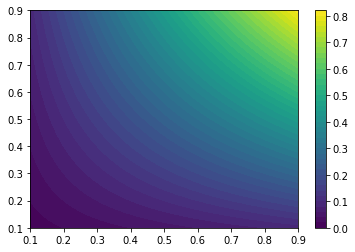

In [48]:
plt.contourf(X,Y,Z,levels = 50)
plt.colorbar()

plt.savefig('myfig.png')

In [49]:
from IPython.display import Image

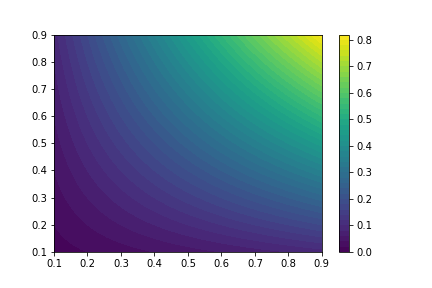

In [50]:
Image("myfig.png")

In [45]:
nrows,ncols = X.shape

In [ ]:
for i in range(nrows):
    for j in range(ncols):
        x = X[i,j]
        y = Y[i,j]
        #.... calculate z
        Z[i,j] = z